[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/2.simple_rcnn.ipynb)

# Система распознавания дорожных знаков на датасете RTSD
## Простой вариант обучения Faster R-CNN для детекции 155 классов (слабый baseline)

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip -d ./data/RTSD
    !rm rtsd-dataset.zip
    !cp -r data/RTSD/rtsd-frames/rtsd-frames/ data/RTSD/
    !rm -r data/RTSD/rtsd-frames/rtsd-frames/
    !pip install fiftyone

In [2]:
import os
import time

import fiftyone as fo
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as func

### Пути и параметры

In [3]:
dataset_path = 'data/RTSD'
checkpoints_path = 'checkpoints' if colab == False else '../content/drive/MyDrive/TSR/checkpoints'
model_name = 'resnet50v2_all_classes'

n_epochs = 10
batch_size = 8
num_classes = 156

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)

NVIDIA GeForce RTX 3090


### Загрузчик данных

In [4]:
class RTSD_dataset(Dataset):
    '''
    Faster R-CNN при обучении ожидает на вход:
    - список тензоров размерностью [C, H, W] для каждого изображения со значениями в диапазоне 0-1
    - таргет: список словарей с ключами:
                - boxes (FloatTensor[N, 4]): ограничивающие рамки ground-truth в формате [x1, y1, x2, y2], с 0 <= x1 < x2 <= W и 0 <= y1 < y2 <= H.
                - labels (Int64Tensor[N]): метки классов для каждой ограничивающей рамки ground-truth (включая background)
    '''
    
    
    def __init__(self, root, annotation, transforms=None):
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Файл coco
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: получение ID аннотаций из coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: загрузка аннатаций для изображения
        coco_annotation = coco.loadAnns(ann_ids)
        # Путь к изображению
        path = coco.loadImgs(img_id)[0]['file_name']
        # Загрузка изображения
        img = Image.open(os.path.join(self.root, path))

        # Количество объектов на изображении
        num_objs = len(coco_annotation)
        
        # Bounding boxes для объектов
        # В coco формате bbox = [xmin, ymin, width, height]
        # Для pytorch bbox должны быть в формате [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Метки классов
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Аннотация в формате словаря
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [5]:
# преобразование изображения в тензор
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [6]:
train_dataset = RTSD_dataset(root=dataset_path,
                             annotation=os.path.join(dataset_path, 'train_anno.json'),
                             transforms=get_transform()
                             )

val_dataset = RTSD_dataset(root=dataset_path,
                           annotation=os.path.join(dataset_path, 'val_anno.json'),
                           transforms=get_transform()
                           )

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### Формирование батча

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
    )

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
    )

In [11]:
for data in train_data_loader:
    images, targets = data[0], data[1]
    break

In [14]:
targets

({'boxes': tensor([[1065.,  121., 1129.,  184.],
          [1069.,  183., 1134.,  245.]]),
  'labels': tensor([57,  4])},
 {'boxes': tensor([[1079.,  331., 1108.,  358.]]), 'labels': tensor([7])},
 {'boxes': tensor([[1094.,  273., 1128.,  306.]]), 'labels': tensor([26])},
 {'boxes': tensor([[   0.,  332.,   62.,  394.],
          [   0.,  407.,   63.,  438.],
          [1428.,  270., 1463.,  336.],
          [1414.,  338., 1473.,  370.]]),
  'labels': tensor([  7, 122,   7, 122])},
 {'boxes': tensor([[855., 289., 885., 318.],
          [856., 320., 882., 344.]]),
  'labels': tensor([ 1, 63])},
 {'boxes': tensor([[ 769.,  311.,  801.,  343.],
          [1085.,  320., 1108.,  342.],
          [ 728.,  344.,  748.,  362.]]),
  'labels': tensor([1, 7, 7])},
 {'boxes': tensor([[839., 300., 900., 358.],
          [841., 358., 900., 388.]]),
  'labels': tensor([2, 5])},
 {'boxes': tensor([[230., 276., 264., 310.]]), 'labels': tensor([15])})

### Инициализация модели, задание оптимизатора и функции потерь

In [8]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [9]:
model = create_model(num_classes=num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# learning rate scheduler уменьшает learning rate в 10 раз каждые 3 эпохи
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

### Трейн луп

In [10]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader} на обучающей выборке. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    len_dataloader = len(val_dataloader)
    running_loss = 0
    for i, data in enumerate(val_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader} на тестовой выборке. Loss: {loss}")
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [11]:
train_losses = []
val_losses = []
try:
    torch.save(model, os.path.join(checkpoints_path, f'model_{model_name}.pth'))
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses,
                    }, os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'))

except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774 на обучающей выборке. Loss: 4.870737075805664
	Эпоха 0. Итерация 50/6774 на обучающей выборке. Loss: 0.2959800660610199
	Эпоха 0. Итерация 100/6774 на обучающей выборке. Loss: 0.4345476031303406
	Эпоха 0. Итерация 150/6774 на обучающей выборке. Loss: 0.26420533657073975
	Эпоха 0. Итерация 200/6774 на обучающей выборке. Loss: 0.4213874936103821
	Эпоха 0. Итерация 250/6774 на обучающей выборке. Loss: 0.24070952832698822
	Эпоха 0. Итерация 300/6774 на обучающей выборке. Loss: 0.15361906588077545
	Эпоха 0. Итерация 350/6774 на обучающей выборке. Loss: 0.23922733962535858
	Эпоха 0. Итерация 400/6774 на обучающей выборке. Loss: 0.498391717672348
	Эпоха 0. Итерация 450/6774 на обучающей выборке. Loss: 0.3942912220954895
	Эпоха 0. Итерация 500/6774 на обучающей выборке. Loss: 0.29100939631462097
	Эпоха 0. Итерация 550/6774 на обучающей выборке. Loss: 0.21472826600074768
	Эпоха 0. Итерация 600/6774 на обучающей выборке. Loss: 0.12603454291820526
	Эпоха 0. Итерация 650/

### Графики лоссов

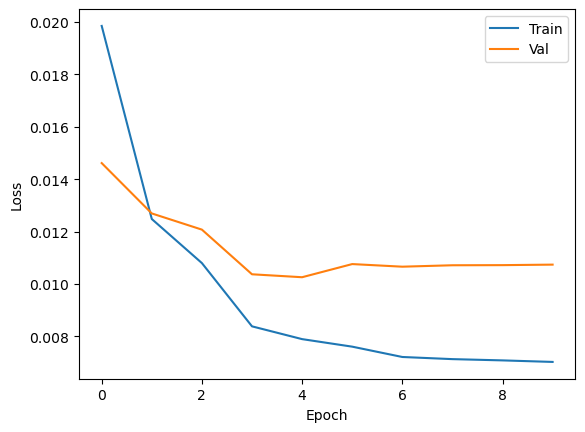

In [16]:
%matplotlib inline
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend();

### Загрузка весов модели с наименьшим лоссом на валидации (с помощью библиотеки FiftyOne)

In [32]:
# выбираем эпоху с наименьшем лоссом на валидации для загрузки весов
epoch = val_losses.index(min(val_losses))
print(f'Минимальный loss на валидации: {min(val_losses):.4f} на {epoch} эпохе')

# загружаем веса модели с наименьшем лоссом на валидации
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Для модели {model_name} загружены веса эпохи {epoch}")

Минимальный loss на валидации: 0.0103 на 4 эпохе
Для модели resnet50v2_all_classes загружены веса эпохи 4


## Рассчет метрик модели на валидационной выборке

Загрузка валидационной выборки

In [42]:
val_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=dataset_path,
    labels_path=os.path.join(dataset_path, 'val_anno.json')
)

 100% |███████████████| 5000/5000 [4.0s elapsed, 0s remaining, 1.3K samples/s]      


In [44]:
# Добавление и оценка детекций Faster-RCNN
# Faster-RCNN могут быть вычислены и добавлены к каждом сэмпле набора данных в новом поле
classes = val_dataset.default_classes
# Добавление предсказаний
model.eval()
for i, sample in enumerate(val_dataset):
    image = Image.open(sample.filepath)
    image = func.to_tensor(image).to(device)
    c,h,w = image.shape
    preds = model([image])[0]
    labels = preds['labels'].cpu().detach().numpy()
    scores = preds['scores'].cpu().detach().numpy()
    boxes = preds['boxes'].cpu().detach().numpy()
    detections = []
    for label, score, box in zip (labels, scores, boxes):
        x1, y1, x2, y2 = box
        rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
        detections.append(fo.Detection(label=classes[label],
                                        bounding_box=rel_box,
                                        confidence=score
                                        )
                            )
    sample['faster_rcnn'] = fo.Detections(detections=detections)
    sample.save()
    if i % 100 == 0:
            print(f'\tОбработано {i} из {val_dataset.__len__()} сэмплов.', end='\r')
print(f'\tОбработано {val_dataset.__len__()} сэмплов.        ')

	Обработано 5000 сэмплов.        


In [45]:
session = fo.launch_app(val_dataset)

In [48]:
# Оценка детекций в поле 'faster_rcnn' нашего 'high_conf_view'
# относительно объектов в поле 'ground_truth'

results = val_dataset.evaluate_detections(
            "faster_rcnn",
            gt_field="detections",
            eval_key="eval",
            compute_mAP=True,
            )
model_metrics = results.metrics()
model_metrics['mAP'] = results.mAP()
model_metrics

Evaluating detections...
 100% |███████████████| 5000/5000 [11.4s elapsed, 0s remaining, 505.9 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [11.3s elapsed, 0s remaining, 499.7 samples/s]      


{'accuracy': 0.6207415907623898,
 'precision': 0.6302796387998835,
 'recall': 0.976201218136702,
 'fscore': 0.765996990884149,
 'support': 8866,
 'mAP': 0.5578250144069918}

F1 на слабом baseline составила 0.766